# HW3 - Model evaluation on Breast cancer dataset

### Data input and prep

In [3]:
# To write a Python 2/3 compatible codebase, the first step is to add this line to the top of each module
from __future__ import division, print_function, unicode_literals
from sklearn.preprocessing import LabelEncoder
import numpy as np # np is an alias pointing to numpy
import pandas as pd # pd is an alias pointing to pandas
#pd.set_option('display.max_columns', 50) #increasing no columns to display 
#pd.set_option('display.width', 120) #increasing panda output window width
# reading data from URL
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",header=None)
# dropping columns that seem to cause multicollinearity in data
df2= df.copy()
df2.drop(df2.columns[[2,5,12,14,22,24,25]],axis=1, inplace = True)
#split dataset into features and target variable
X = df2.iloc[:,2:]# Features
y = df2[1] # Target variable
#classes = ['B', 'M' ]
le = LabelEncoder()
y = le.fit_transform(y) #Labels 'M' as 1 and 'B' as 0
print(le.classes_)      #Show the classes that have been encoded

['B' 'M']


### Decision Tree classifier - Hyperparameter optimization

In [4]:
############################### Import Libraries & Modules #################################

from sklearn.tree import DecisionTreeClassifier # A decision tree classifier
# GridSearchCV performs an exhaustive search over specified parameter values for an estimator
# The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn import neighbors
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler

np.random.seed(42) # Ensure reproducability

################################# Nested Cross-Validation #################################

##################################### Parameter Tuning ####################################

# Exhaustive search over specified parameter values for an estimator.
# GridSearchCV implements a “fit” and a “score” method. 
# It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” 
# if they are implemented in the estimator used.

# The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.

inner_cv = KFold(n_splits=5, shuffle=True)
outer_cv = KFold(n_splits=5, shuffle=True)
    
############################## Decision Tree Parameter Tuning ##############################

# Choosing depth of the tree AND splitting criterion AND min_samples_leaf AND min_samples_split
gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6,7,8,9,10, None], 'criterion':['gini','entropy'], 
                              'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
                              'min_samples_split':[2,3,4,5,6,7,8,9,10]}],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_dt = gs_dt.fit(X,y)
print("\n Parameter Tuning - Decision Tree")
print("Non-nested CV F1 Score: ", gs_dt.best_score_)
print("Optimal Parameter: ", gs_dt.best_params_)
print("Optimal Estimator: ", gs_dt.best_estimator_)
nested_score_gs_dt = cross_val_score(gs_dt, X=X, y=y, cv=outer_cv)
print("Nested CV F1 Score: ",nested_score_gs_dt.mean(), " +/- ", nested_score_gs_dt.std())


 Parameter Tuning - Decision Tree
Non-nested CV F1 Score:  0.9187092928843348
Optimal Parameter:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 4}
Optimal Estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Nested CV F1 Score:  0.8861626590128834  +/-  0.03336320589494249


### Logistic Regression - Hyperparameter optimization

In [13]:
############################ Logistic Regression Parameter Tuning ############################
# Choosing C parameter for Logistic Regression AND type of penalty (ie., l1 vs l2)
# See other parameters here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

import sys ,warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
gs_lr = GridSearchCV(estimator=LogisticRegression(),
                  param_grid=[{'C': [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000, 10000000],
                             'penalty':['l1','l2']}],
                  scoring='f1',
                  cv=inner_cv)

gs_lr = gs_lr.fit(X,y)
print("\n Parameter Tuning Logistic Regression")
print("Non-nested CV F1 Score: ", gs_lr.best_score_)
print("Optimal Parameter: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)
nested_score_gs_lr = cross_val_score(gs_lr, X=X, y=y, cv=outer_cv)
print("Nested CV F1 Score:",nested_score_gs_lr.mean(), " +/- ", nested_score_gs_lr.std())


 Parameter Tuning Logistic Regression
Non-nested CV F1 Score:  0.9620967172239426
Optimal Parameter:  {'C': 1000, 'penalty': 'l2'}
Optimal Estimator:  LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Nested CV F1 Score: 0.9524109806131253  +/-  0.040942408812798155


### KNN algorithm - Hyperparameter optimization

In [15]:
################################### kNN Parameter Tuning ###################################

#Normalize Data
sc = StandardScaler()
#sc.fit(X_train)
sc.fit(X)
X_std = sc.transform(X)
#X_train_std = sc.transform(X_train)
#X_test_std = sc.transform(X_test)


# Choosing k for kNN AND type of distance
gs_knn = GridSearchCV(estimator=neighbors.KNeighborsClassifier(p=2, 
                           metric='minkowski'),
                  param_grid=[{'n_neighbors': [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29],
                               'weights':['uniform','distance']}],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_knn = gs_knn.fit(X_std,y)  
print("\n Parameter Tuning - KNN algorithm")
print("Non-nested CV F1 Score: ", gs_knn.best_score_)
print("Optimal Parameter: ", gs_knn.best_params_)
print("Optimal Estimator: ", gs_knn.best_estimator_) # Estimator that was chosen by the search, i.e. estimator which gave highest score
nested_score_gs_knn = cross_val_score(gs_knn, X=X_std, y=y, cv=outer_cv)
print("Nested CV F1 Score: ",nested_score_gs_knn.mean(), " +/- ", nested_score_gs_knn.std())


 Parameter Tuning - KNN algorithm
Non-nested CV F1 Score:  0.9391446659677958
Optimal Parameter:  {'n_neighbors': 9, 'weights': 'uniform'}
Optimal Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')
Nested CV F1 Score:  0.9234809517894849  +/-  0.02175652225306678


### Learning Curve for Logistic Regression

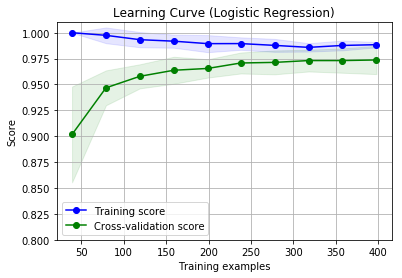

In [16]:
############################## Function for Learning Curves ##############################

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()                    #display figure
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples") #y label title
    plt.ylabel("Score")             #x label title
    
    # Class learning_curve determines cross-validated training and test scores for different training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Cross validation statistics for training and testing data (mean and standard deviation)
    train_scores_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # Compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # Compute the standard deviation along the specified axis.

    plt.grid() # Configure the grid lines

    # Fill the area around the line to indicate the size of standard deviations for the training data
    # and the test data
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b") # train data performance indicated with blue
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") # test data performance indicated with green
    
    # Cross-validation means indicated by dots
    # Train data performance indicated with blue
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    # Test data performance indicated with green
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best") # Show legend of the plot at the best location possible
    return plt             # Function that returns the plot as an output


########################### Visualization of Learning Curves ###########################

# Determines cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve 
# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, 
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt

title = "Learning Curve (Logistic Regression)"

# Class ShuffleSplit is a random permutation cross-validator
# Parameter n_splits = Number of re-shuffling & splitting iterations
# Parameter test_size = represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
# Parameter random_state = the seed used by the random number generator
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = LogisticRegression(C= 1000,penalty= 'l2') # Build multiple LRs as we increase the size of the traning data
# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator, title, X, y, (0.8, 1.01), cv=cv, n_jobs=4)

plt.show() # Display the figure

### Fitting Curve for decision tree classifier

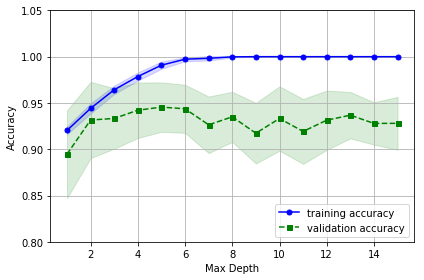

In [11]:
############################### Import Libraries & Modules #################################

# Fitting curve (aka validation curve)
# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve
# Split validation
from sklearn.model_selection import train_test_split
############################# Parameters - Varying Complexity #############################

# Specify possible parameter values for max_depth.
#'max_depth': [1, 2, 3, 4, 5, 6,7,8,9,10, None]
param_range = [1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15]


# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeClassifier(), #Build Decision Tree model
                X=X, 
                y=y, 
                param_name="max_depth", 
                param_range=param_range,
                cv=10,     #10-fold cross-validation
                scoring="accuracy", 
                n_jobs=4) # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. This parameter is ignored when the ``solver``is set to ‘liblinear’ regardless of whether ‘multi_class’ is specified or not. If given a value of -1, all cores are used.


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
train_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters max depth in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters max depth in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
#plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.05]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           # Display the figure

### ROC curve for decision tree, logistic regression and KNN

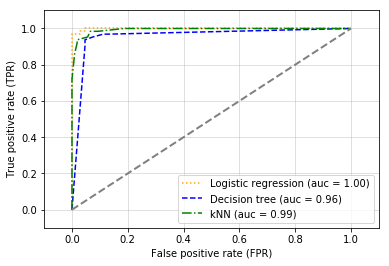

In [19]:
############################### Import Libraries & Modules #################################
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.neighbors import KNeighborsClassifier 

######################################## Classifiers ########################################

# Logistic Regression Classifier
clf1 = LogisticRegression(penalty='l2',C=1000)

# Decision Tree Classifier
clf2 = DecisionTreeClassifier(max_depth=7,criterion='gini',min_samples_leaf= 5,min_samples_split=4)

# kNN Classifier
clf3 = KNeighborsClassifier(n_neighbors=9,p=2,metric='minkowski',weights= 'uniform')

# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [clf1, clf2, clf3]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,stratify=y)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # Colors for visualization
linestyles = [':', '--', '-.', '-']        # Line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):
    if clf == clf3:
        # Assuming the label of the positive class is 1 and data is normalized
        y_pred = clf.fit(X_train_std,y_train).predict_proba(X_test_std)[:, 1] # Make predictions based on the classifiers
        fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
        plt.plot(fpr, tpr,color=clr,linestyle=ls,label='%s (auc = %0.2f)' % (label, roc_auc))
    else:
        # Assuming the label of the positive class is 1 and data is normalized
        y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
        fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
        plt.plot(fpr, tpr,color=clr,linestyle=ls,label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()